In [1]:
%pprint

Pretty printing has been turned OFF


In [2]:
import os
import json

import torch

from tqdm import tqdm

from src.env import PuzzleEnv
from src.agent import Agent
from src.dqn import DQN
from src.visualization.plotting import (
    imshow_cube,
    plot_history,
    plot_success_length,
    plot_success_rate,
)
from src.train.result_utils import ResultManager, save_history

device = "cpu"

In [3]:
env_config = {
    "exp_name": "C3_m=10_ms=50",
    "description": "up to 10 shuffles, and trying longer steps",
    "puzzle_name": "cube_3x3x3",
    "num_envs": 256,
    "max_steps": 50,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 10],
        "extra_generation": 4,
    },
    "reward_config": {
        "success": 10,
        "time": -0.1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "epsilon_schedule": "exp",
    "epsilon_start": 0.9,
    "epsilon_end": 0.05,
    "epsilon_decay": 100000,
    "tau": 0.005,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "network_units": [128, 256, 128],
}

Loaded cube_3x3x3: 18 actions, 54 states


In [4]:
env = PuzzleEnv(env_config)
agent = Agent(agent_config)


# initiate history template
history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        f"{n}": [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}


def train(env, agent, episodes, history):
    s = env.reset()
    s = torch.tensor(s, device=device)
    for _ in tqdm(range(episodes)):
        for _ in range(env_config["max_steps"]):
            a = agent.select_action(s)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)

            loss = agent.optimize(s, a, r, s_n, terminated, mask)
            s = s_n
            agent.update_target_net()

        history["loss"].append(loss)
        history["reward"].append(
            env.get_cumulative_reward().sum().item() / env.num_envs
        )
        (
            success_rate_per_n,
            success_length_per_n,
            average_success,
        ) = env.get_completion_rate()
        history["avg_success"].append(average_success)
        for n in success_rate_per_n.keys():
            history["success_per_n"][f"{n}"].append(success_rate_per_n[n])
            history["success_length_per_n"][f"{n}"].append(success_length_per_n[n])

Loaded cube_3x3x3: 18 actions, 54 states


In [ ]:
# env, agent, history = load_experiment("results/C3_test")

In [5]:
train(env, agent, episodes=5000, history=history)
print(sum(history["avg_success"][-100:]) / len(history["avg_success"][-100:]))

100%|██████████| 5000/5000 [14:59<00:00,  5.56it/s]

0.33700520837239595


In [6]:
def load_experiment(exp_folder):
    for f in [
        "env_config.json",
        "agent_config.json",
        "history.json",
        "target_net.pt",
        "policy_net.pt",
    ]:
        if f not in os.listdir(exp_folder):
            print(f"Warning: did not find {f} in {exp_folder}")
            return
    print("found all files, loading configs...")
    with open(os.path.join(exp_folder, "env_config.json"), "r+") as f:
        env: PuzzleEnv = PuzzleEnv(json.load(f))
    with open(os.path.join(exp_folder, "agent_config.json"), "r+") as f:
        agent: Agent = Agent(json.load(f))

    print("loading network checkpoints...")
    agent.target_network = torch.load(os.path.join(exp_folder, "target_net.pt"))
    agent.policy_network = torch.load(os.path.join(exp_folder, "policy_net.pt"))
    agent.optimizer = torch.load(os.path.join(exp_folder, "optimizer.pt"))

    with open(os.path.join(exp_folder, "history.json")) as f:
        history = json.load(f)
    print("successfully loaded checkpoint")
    return env, agent, history

In [7]:
result_manager = ResultManager(agent, env)

saving configs...
saved env and agent configs
saving networks...
saved policy network and target networks


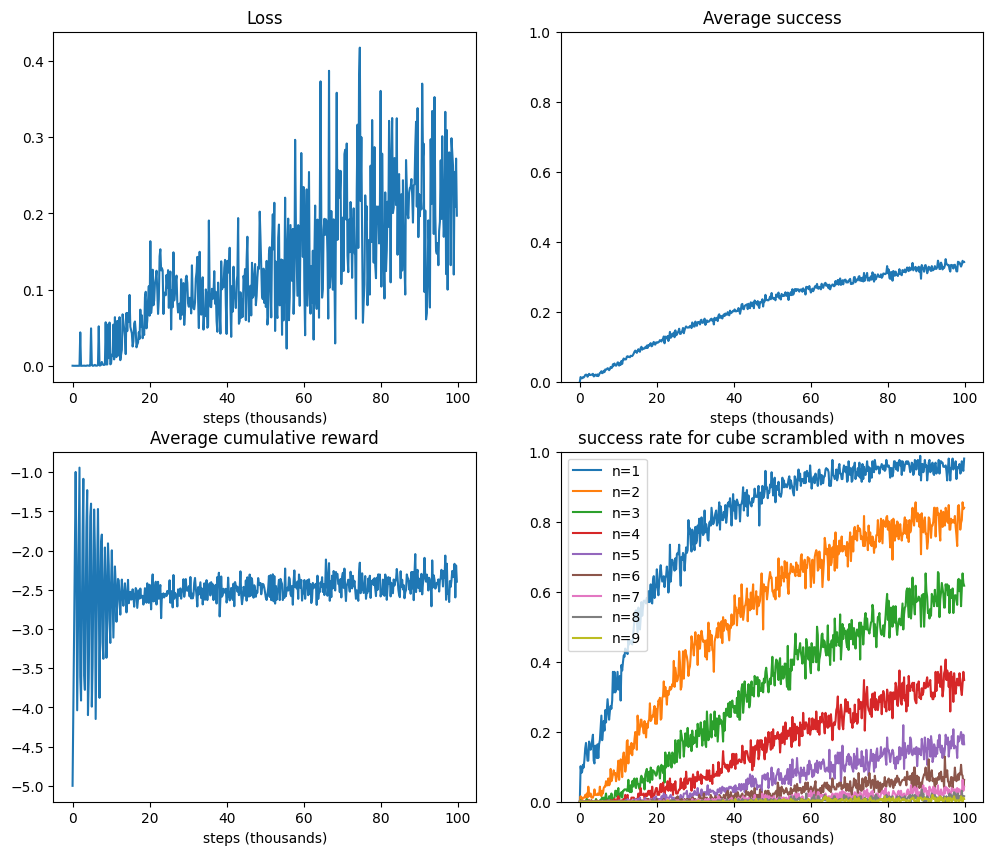

In [8]:
result_manager.save()

save_history(history, result_manager.directory)
plot_history(history, episode_length=20, save_to_folder=result_manager.directory)

In [12]:
eval_stats = result_manager.evaluate(steps=2500)

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:06<00:00, 401.97it/s]


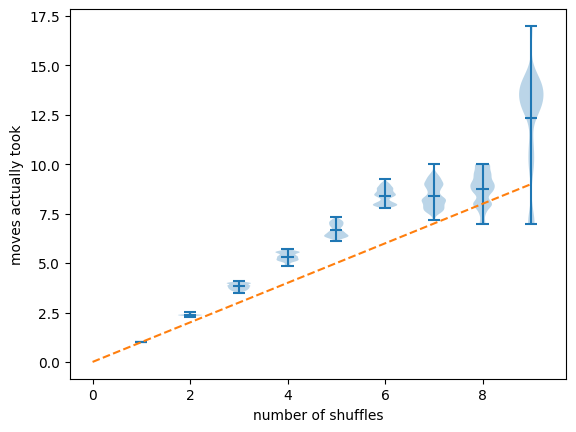

In [13]:
plot_success_length(
    eval_stats["success_length_per_n"], save_to_folder=result_manager.directory
)

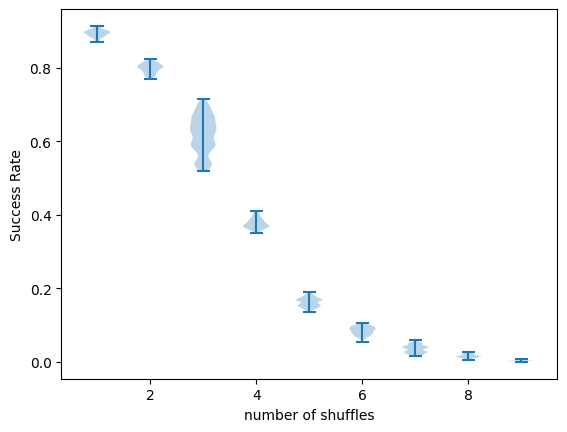

In [14]:
plot_success_rate(eval_stats["success_per_n"], save_to_folder=result_manager.directory)